<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

# Установка пакетов
!pip install --upgrade ipykernel -q
!pip install --upgrade pip -q
!pip install matplotlib -q
!pip install scikit-learn==1.6.1 -q
!pip install shap -q
!pip install --upgrade scikit-learn -q
!pip install phik -q
!pip install ipython -q
!pip install category-encoders -q
!pip install lightgbm -q

# Импорты библиотек
from category_encoders import BinaryEncoder
import time
import warnings
from IPython.display import display

# Создание констант
RANDOM_STATE = 42
TEST_SIZE = 0.1

# Импорты для визуализации
import matplotlib.pyplot as plt
import plotly.express as px
plt.rcParams["figure.figsize"] = (10,5)
import seaborn as sns

# Импорты для работы с данными
import numpy as np
from scipy.stats import uniform, randint

# Импорты из scikit-learn
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split,
    cross_val_score,
    cross_val_predict,
    TimeSeriesSplit
)
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error

# Импорты специфичных библиотек
import lightgbm as lgb
import catboost as cb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from category_encoders import TargetEncoder
import category_encoders
from statsmodels.tsa.stattools import adfuller

<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  на месте
</div>



In [ ]:
#Считываем файл с данными и записываем датасет в переменную
try:
    taxi = pd.read_csv('taxi.csv', engine = 'python', sep = ',',
                        parse_dates=[0])
    taxi.columns = taxi.columns.str.lower()
except:
    taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', sep = ',',
                        parse_dates=[0] )
    taxi.columns = taxi.columns.str.lower()

In [ ]:
taxi.info()
display (taxi.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [ ]:
# Устанавливаем столбец datetime как индекс
taxi.set_index('datetime', inplace=True)

# Ресемплирование по одному часу, суммируем num_orders
taxi_resampled = taxi.resample('1H').sum()

display ("Ресемплированный датасет:", taxi_resampled)

'Ресемплированный датасет:'

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


На этапе подготовки был загружен датасет и проведено его ресемплирование данных по 1 часу.

## Анализ

In [ ]:
taxi_resampled.info()
#Изучим дополнительную информацию по числовым значениям
taxi_resampled.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
count,"4,416.00"
mean,84.42
std,45.02
min,0.00
25%,54.00
50%,78.00
75%,107.00
max,462.00


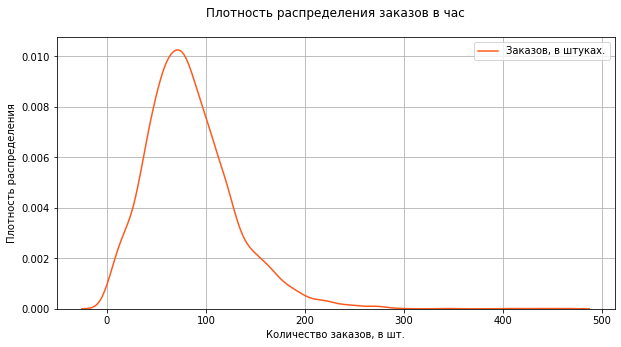

In [ ]:
#Построим график плотности распределения непрерывного значения кол-ва заказов
sns.kdeplot(taxi_resampled['num_orders'], color='#fe5a1d', label='Заказов, в штуках.', alpha=0.5)
plt.legend(loc='best')
plt.title('Плотность распределения заказов в час', pad=20)
plt.xlabel('Количество заказов, в шт.')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

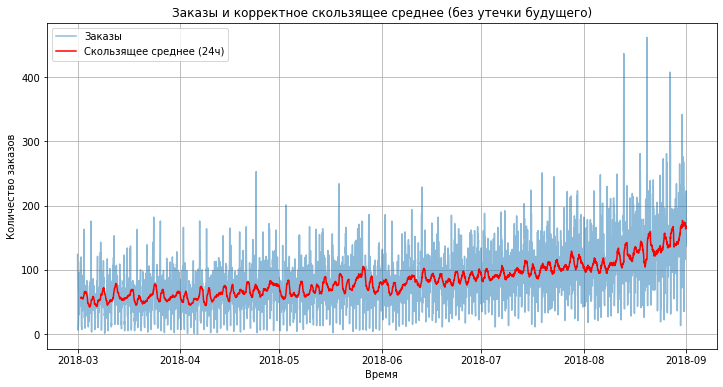

In [ ]:
# Использую shift()
taxi_resampled['rolling_mean'] = taxi_resampled['num_orders'].shift().rolling(24, closed='left').mean()

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(taxi_resampled['num_orders'], label='Заказы', alpha=0.5)
plt.plot(taxi_resampled['rolling_mean'], label='Скользящее среднее (24ч)', color='red')
plt.title('Заказы и корректное скользящее среднее (без утечки будущего)')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid()
plt.show()

По графику видно, что есть сезонность по месяцам: в начале года заказов в час почти в 2 раза меньше, чем в августе

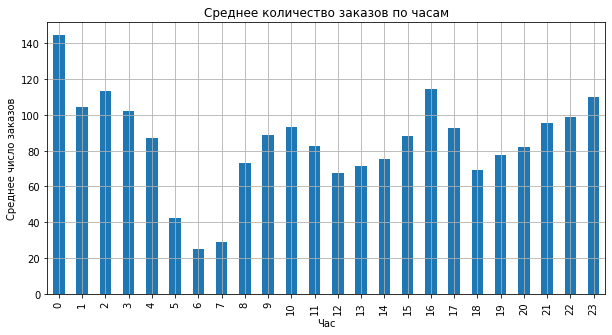

In [ ]:
#Проанализируем среднее количество заказов по часам:
taxi_resampled['hour'] = taxi_resampled.index.hour
hourly_orders = taxi_resampled.groupby('hour')['num_orders'].mean()
hourly_orders.plot(kind='bar')
plt.title('Среднее количество заказов по часам')
plt.xlabel('Час')
plt.ylabel('Среднее число заказов')
plt.grid()
plt.show();

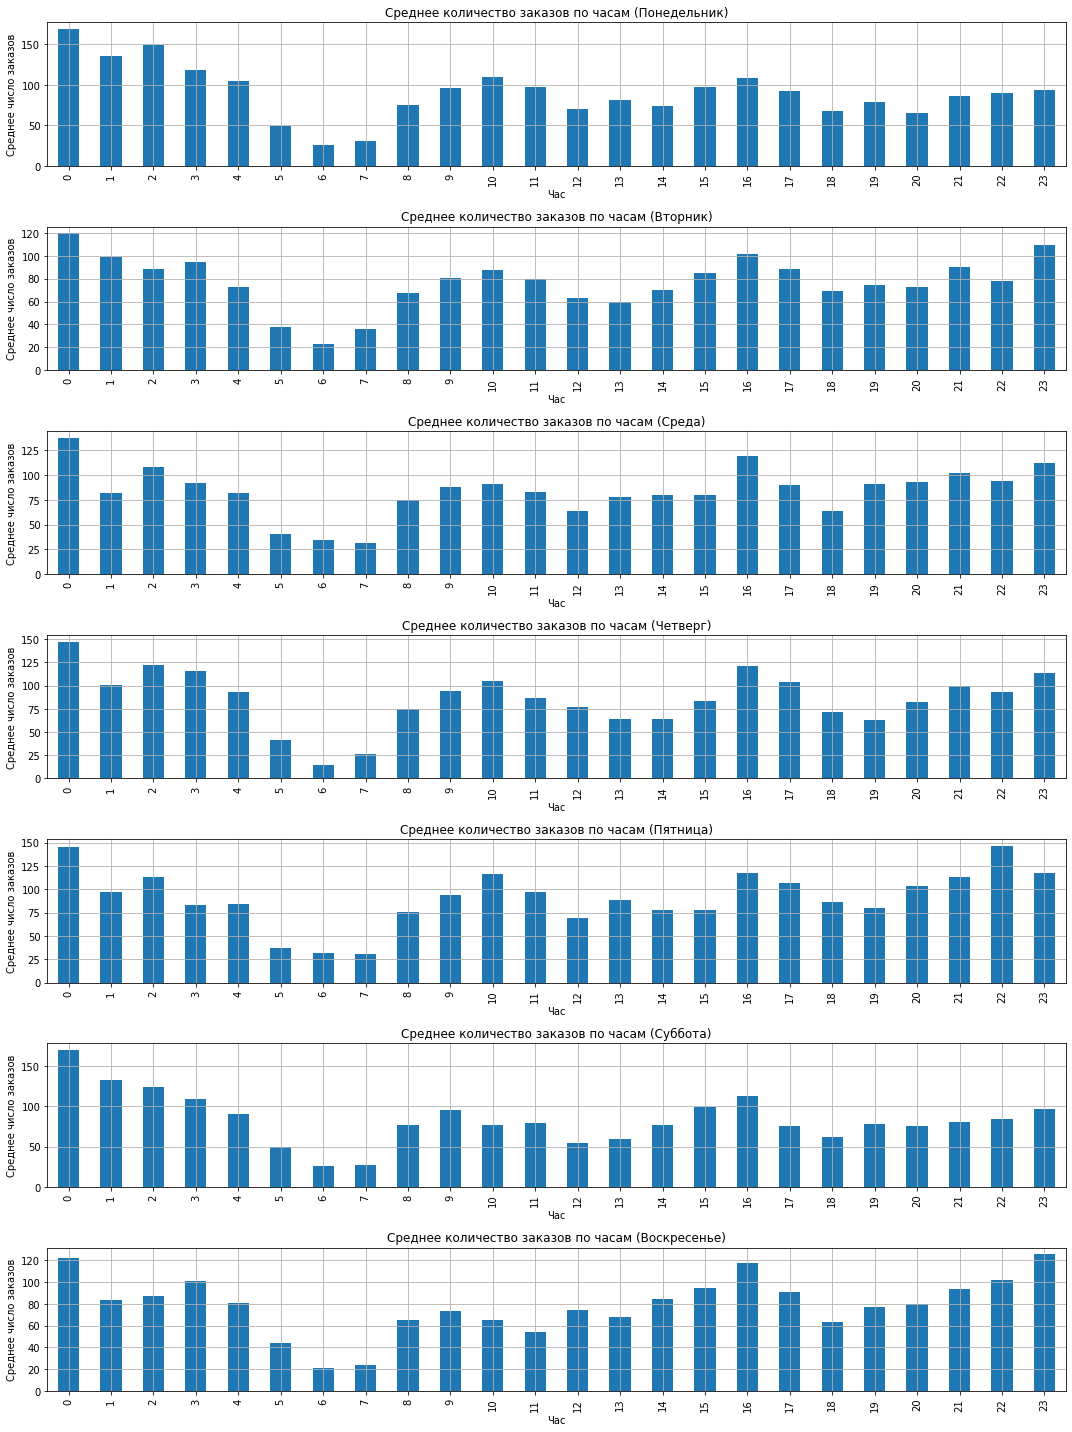

In [ ]:
#Проанализируем, как заказы варьируются по дням недели:
taxi_resampled['hour'] = taxi_resampled.index.hour
taxi_resampled['day_of_week'] = taxi_resampled.index.dayofweek

# Создаем 7 графиков (по одному для каждого дня недели)
days = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
plt.figure(figsize=(15, 20))

for day in range(7):
    # Фильтруем данные для текущего дня недели
    day_data = taxi_resampled[taxi_resampled['day_of_week'] == day]
    # Группируем по часам и вычисляем среднее количество заказов
    hourly_orders = day_data.groupby('hour')['num_orders'].mean()

    # Создаем подграфик (7 строк, 1 столбец)
    plt.subplot(7, 1, day + 1)
    hourly_orders.plot(kind='bar')
    plt.title(f'Среднее количество заказов по часам ({days[day]})')
    plt.xlabel('Час')
    plt.ylabel('Среднее число заказов')
    plt.grid(True)
    plt.tight_layout()

plt.show();

Также прослеживается дневная сезонность - больше всего заказов в 0ч, в 16 ч, в 23ч.с 0 часов идет спад к 6 утра, далее небольшой рост числа заказов к 9 утра, далее спад к 11-12 часам , рост к 16 ч., спад к 18ч. и снова рост к 23ч.

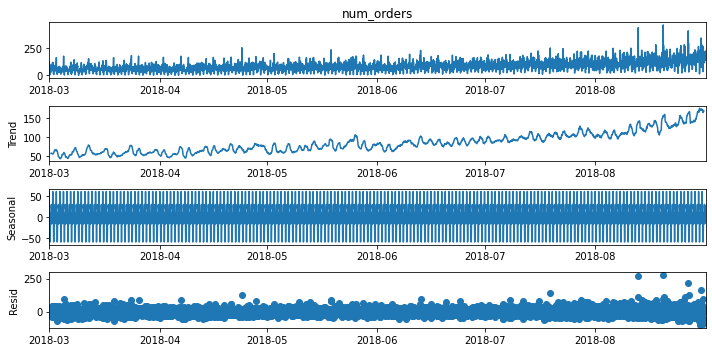

In [ ]:
#Проверим, есть ли общий рост или спад числа заказов с течением времени
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(taxi_resampled['num_orders'], model='additive', period=24)
decomposition.plot()
plt.show();

Виден тренд на рост заказов с начала года до августа.

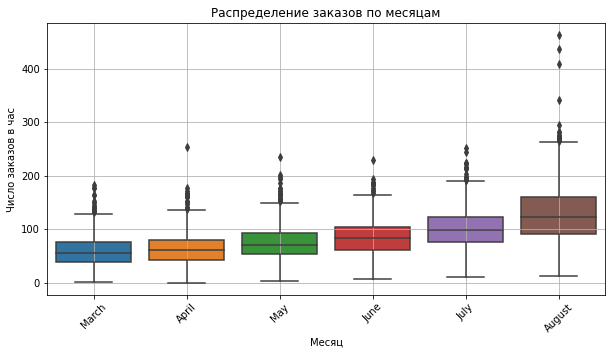

In [ ]:
#Проведем почасовой анализ числа заказов по месяцам
taxi_resampled['month'] = taxi_resampled.index.month_name()
taxi_resampled['month_num'] = taxi_resampled.index.month

# Сумма заказов по месяцам
monthly_orders = taxi_resampled.groupby(['month_num', 'month'])['num_orders'].sum().reset_index()
monthly_orders = monthly_orders.sort_values('month_num')  # сортируем по номеру месяца

sns.boxplot(data=taxi_resampled, x='month', y='num_orders', order=monthly_orders['month'])
plt.title('Распределение заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Число заказов в час')
plt.xticks(rotation=45)
plt.grid()
plt.show();

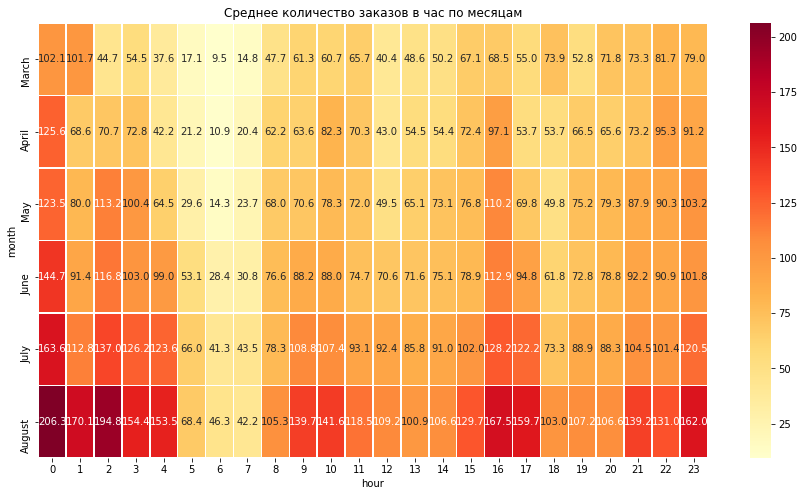

In [ ]:
# Построим тепловую карту распределения числа заказов по месяцам
month_hour_orders = taxi_resampled.groupby(['month_num', 'month', 'hour'])['num_orders'].mean().reset_index()

# Тепловая карта: месяц vs час
pivot_data = month_hour_orders.pivot(index='month', columns='hour', values='num_orders')
pivot_data = pivot_data.loc[monthly_orders['month']]  # сортируем месяцы

plt.figure(figsize=(15, 8))
sns.heatmap(pivot_data, cmap='YlOrRd', annot=True, fmt='.1f', linewidths=0.5)
plt.title('Среднее количество заказов в час по месяцам')
plt.show()

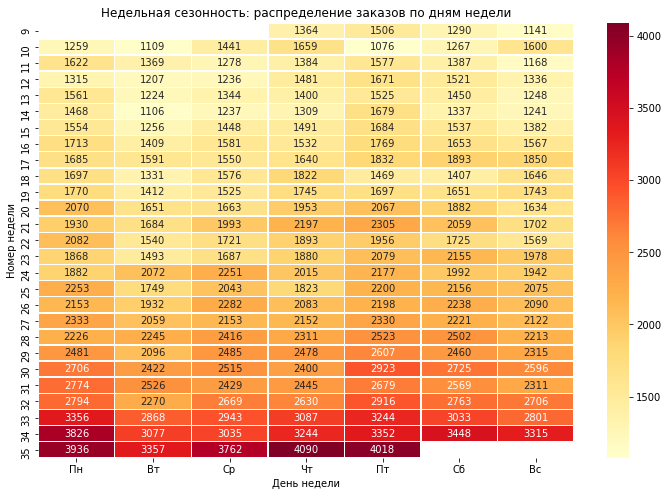

In [ ]:
# Ресемплируем по дням и суммируем заказы
daily_data = taxi.resample('D')['num_orders'].sum().to_frame()

# Добавляем день недели и номер недели
daily_data['day_of_week'] = daily_data.index.dayofweek
daily_data['week_num'] = daily_data.index.isocalendar().week

# Создаем таблицу: недели vs дни недели
weekly_pivot = daily_data.pivot_table(
    index='week_num',
    columns='day_of_week',
    values='num_orders',
    aggfunc='sum'
)

weekly_pivot.columns = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
plt.figure(figsize=(12, 8))
sns.heatmap(weekly_pivot, cmap='YlOrRd', annot=True, fmt='.0f', linewidths=0.5)
plt.title('Недельная сезонность: распределение заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Номер недели')
plt.show()

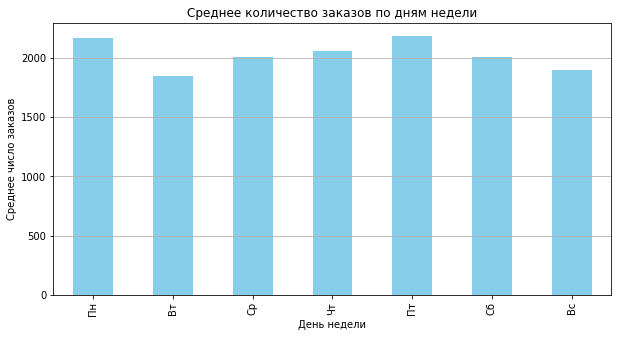

In [ ]:
# Среднее количество заказов по дням недели
weekday_avg = daily_data.groupby('day_of_week')['num_orders'].mean()
weekday_avg.index = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

weekday_avg.plot(kind='bar', color='skyblue')
plt.title('Среднее количество заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Среднее число заказов')
plt.grid(axis='y')
plt.show()

Также прослеживается сезонность по дням недели - больше вчего заказовпо понедельникам и пятницам, меньше всего - во вторник.

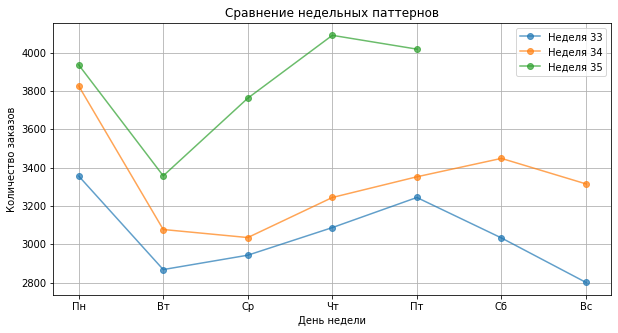

In [ ]:
# Выбираем последние недели для детального сравнения
sample_weeks = weekly_pivot.iloc[24:28]

for i, (week_num, week_data) in enumerate(sample_weeks.iterrows()):
    plt.plot(week_data.values, label=f'Неделя {week_num}', marker='o', alpha=0.7)

plt.title('Сравнение недельных паттернов')
plt.xlabel('День недели')
plt.xticks(range(7), sample_weeks.columns)
plt.ylabel('Количество заказов')
plt.legend()
plt.grid()
plt.show();

Понедельный анализ показывает - еженедельный рост числа заказов от начала года к августу

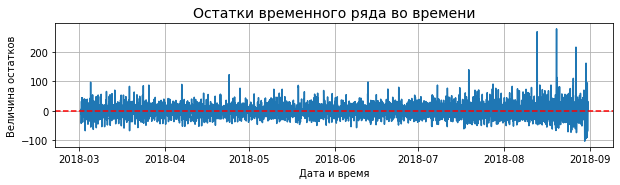

In [ ]:
# Анализ остатков. Декомпозиция временного ряда
decomposition = seasonal_decompose(taxi_resampled['num_orders'],
                                 model='additive',
                                 period=24)
# График остатков во времени
plt.subplot(2, 1, 1)
plt.plot(decomposition.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Остатки временного ряда во времени', fontsize=14)
plt.xlabel('Дата и время')
plt.ylabel('Величина остатков')
plt.grid(True)

По анализу остаткав видно, что они равномерно распраделяются по всему временному ряду, но в августе заметно, что шума становиться больше, чем в других месяцах.

In [ ]:
# Проведем тест Дики-Фуллера для исходного ряда
def adf_test(timeseries):
    display("Тест Дики-Фуллера:")
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Тестовая статистика',
                                           'p-value',
                                           'Кол-во лагов',
                                           'Кол-во наблюдений'])
    for key, value in dftest[4].items():
        dfoutput[f'Критическое значение ({key})'] = value
    display (dfoutput)

    if dftest[1] > 0.05:
        display ("Ряд НЕ стационарен (не отвергаем нулевую гипотезу)")
    else:
        display ("Ряд стационарен (отвергаем нулевую гипотезу)")

# Применяем тест к исходным данным
adf_test(taxi_resampled['num_orders'])

'Тест Дики-Фуллера:'

Тестовая статистика             -3.07
p-value                          0.03
Кол-во лагов                    30.00
Кол-во наблюдений            4,385.00
Критическое значение (1%)       -3.43
Критическое значение (5%)       -2.86
Критическое значение (10%)      -2.57
dtype: float64

'Ряд стационарен (отвергаем нулевую гипотезу)'

In [ ]:
taxi_resampled_clean = taxi_resampled.dropna()
taxi_resampled_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4391 entries, 2018-03-02 01:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4391 non-null   int64  
 1   rolling_mean  4391 non-null   float64
 2   hour          4391 non-null   int64  
 3   day_of_week   4391 non-null   int64  
 4   month         4391 non-null   object 
 5   month_num     4391 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 240.1+ KB


**Выводы по этапу Анализ данных**:  

Тренд по увеличанию числа заказов в течении 8 месяцев постоянный. Число заказов в час уведичилось почти в 2 раза.  
В течении дня также есть паттерн по росту и снжению заказов. Больше всего заказов в 0, 16 и 23 ч., меньше всего в 6-7 утра.  
По анализу остаткав видно, что они распраделяются по всему временному ряду, в августе заметно, что шума больше, чем в других месяцах.  
Понедельный анализ показывает - еженедельный рост числа заказов от начала года к августу.  

Можем переходить к обучению моделей для прогноза числа заказов в пиковые часы нагрузок

## Обучение

Сделаем тестовую выборку для обучения моделей размером 10% от исходных данных.   
Обучим несколько моделей: RandomForestRegressor, CatBoostRegressor и LGBMRegressor с различными гиперпараметрами.   
Для оценки качества модели посчитаем значение метрики RMSE на тестовой выборке.  
Выберем лучшую модель на основании RMSE.    


In [ ]:
# Создаем фичи из даты
taxi_resampled.index = pd.to_datetime(taxi_resampled.index)
taxi_resampled = taxi_resampled.drop(columns=['month', 'month_num'])
taxi_resampled['hour'] = taxi_resampled.index.hour
taxi_resampled['day_of_week'] = taxi_resampled.index.dayofweek

# Лаги
lags = [1, 2, 3, 24]
for lag in lags:
    taxi_resampled[f'lag_{lag}'] = taxi_resampled['num_orders'].shift(lag).fillna(method='bfill')

In [ ]:
taxi_resampled_clean = taxi_resampled.dropna()
taxi_resampled_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4391 entries, 2018-03-02 01:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4391 non-null   int64  
 1   rolling_mean  4391 non-null   float64
 2   hour          4391 non-null   int64  
 3   day_of_week   4391 non-null   int64  
 4   lag_1         4391 non-null   float64
 5   lag_2         4391 non-null   float64
 6   lag_3         4391 non-null   float64
 7   lag_24        4391 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 308.7 KB


In [ ]:
display (taxi_resampled_clean.head(10))

,num_orders,rolling_mean,hour,day_of_week,lag_1,lag_2,lag_3,lag_24
datetime,,,,,,,,
2018-03-02 01:00:00,120,56.83,1,4,90.00,58.00,113.00,85.00
2018-03-02 02:00:00,75,55.42,2,4,120.00,90.00,58.00,71.00
2018-03-02 03:00:00,64,56.88,3,4,75.00,120.00,90.00,66.00
2018-03-02 04:00:00,20,57.04,4,4,64.00,75.00,120.00,43.00
2018-03-02 05:00:00,11,56.96,5,4,20.00,64.00,75.00,6.00
2018-03-02 06:00:00,11,56.00,6,4,11.00,20.00,64.00,12.00
2018-03-02 07:00:00,7,56.21,7,4,11.00,11.00,20.00,15.00
2018-03-02 08:00:00,46,56.17,8,4,7.00,11.00,11.00,34.00
2018-03-02 09:00:00,45,55.83,9,4,46.00,7.00,11.00,69.00


In [ ]:
# Фичи для масштабирования
features_to_scale = ['rolling_mean', 'hour', 'day_of_week', 'lag_1', 'lag_2', 'lag_3', 'lag_24']

# Получаем общий размер данных ДО разделения
total_size = len(taxi_resampled)

# Разделяем на признаки и целевую переменную
X = taxi_resampled[features_to_scale]
y = taxi_resampled['num_orders']

# Разделение на train/test (сохраняем временной порядок)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.1,
    shuffle=False,  # Критически важно для временных рядов!
    random_state=42
)
# Масштабирование только на тренировочных данных
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])

# Размеры выборок
train_size = len(X_train)
test_size = len(X_test)
print("\n=== Размеры выборок ===")
print(f"Общий размер датасета: {total_size} записей")
print(f"Обучающая выборка: {train_size} записей ({train_size/total_size:.1%})")
print(f"Тестовая выборка: {test_size} записей ({test_size/total_size:.1%})")


=== Размеры выборок ===
Общий размер датасета: 4416 записей
Обучающая выборка: 3974 записей (90.0%)
Тестовая выборка: 442 записей (10.0%)


In [ ]:
# Модель 1: RandomForest с подбором гиперпараметров
tscv = TimeSeriesSplit(n_splits=5)

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=3,
    max_features='sqrt',
    bootstrap=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Кросс-валидация
cv_scores = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    X_fold_train, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Обучение на фолде
    rf.fit(X_fold_train, y_fold_train)
    # Предсказание на валидации
    y_pred = rf.predict(X_val)
    # Расчет метрики
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    cv_scores.append(rmse)

    display(f'Fold {fold+1}: RMSE = {rmse:.2f}')
    display(f'Период валидации: {X_val.index.min()} - {X_val.index.max()}\n')

# Оценка среднего значения RMSE качества прогноза модели
display(f'Средний RMSE на кросс-валидации: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}')

rf.fit(X_train, y_train)

'Fold 1: RMSE = 21.54'

'Период валидации: 2018-03-28 16:00:00 - 2018-04-25 05:00:00\n'

'Fold 2: RMSE = 22.83'

'Период валидации: 2018-04-25 06:00:00 - 2018-05-22 19:00:00\n'

'Fold 3: RMSE = 23.67'

'Период валидации: 2018-05-22 20:00:00 - 2018-06-19 09:00:00\n'

'Fold 4: RMSE = 25.16'

'Период валидации: 2018-06-19 10:00:00 - 2018-07-16 23:00:00\n'

'Fold 5: RMSE = 32.78'

'Период валидации: 2018-07-17 00:00:00 - 2018-08-13 13:00:00\n'

'Средний RMSE на кросс-валидации: 25.20 ± 3.97'

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=3,
                      n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
# Модель 2: CatBoost
# Параметры модели
cb_params = {
    'iterations': 500,
    'depth': 8,
    'learning_rate': 0.03,
    'l2_leaf_reg': 5,
    'random_seed': RANDOM_STATE,
    'verbose': False,
    'early_stopping_rounds': 50}

# Кросс-валидация
cv_scores = []
fold_models = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"\nFold {fold + 1}")

    # Разделение данных с сохранением временного порядка
    X_fold_train, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Обучение с валидационным набором
    cb = CatBoostRegressor(**cb_params)
    cb.fit(
        X_fold_train, y_fold_train,
        eval_set=(X_val, y_val),
        use_best_model=True,
        verbose=200
    )
    fold_models.append(cb)

    # Прогноз и оценка
    y_pred = cb.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    cv_scores.append(rmse)

    display(f"Валидационный RMSE: {rmse:.2f}")
    display(f"Даты: {X_val.index.min()} to {X_val.index.max()}")

# Анализ результатов
display(f"Средний RMSE на кросс-валидации: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

# Обучение на всех данных
best_cb = CatBoostRegressor(**cb_params)
best_cb.fit(X_train, y_train, verbose=100)


Fold 1
0:	learn: 29.3455642	test: 30.8259078	best: 30.8259078 (0)	total: 53.1ms	remaining: 26.5s
200:	learn: 13.2578925	test: 21.6484385	best: 21.6484385 (200)	total: 636ms	remaining: 946ms
400:	learn: 11.0860059	test: 21.4715434	best: 21.4701121 (398)	total: 1.2s	remaining: 296ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 21.45259196
bestIteration = 446

Shrink model to first 447 iterations.


'Валидационный RMSE: 21.45'

'Даты: 2018-03-28 16:00:00 to 2018-04-25 05:00:00'


Fold 2
0:	learn: 29.9351189	test: 35.2244116	best: 35.2244116 (0)	total: 7.68ms	remaining: 3.83s
200:	learn: 14.7825824	test: 23.3821700	best: 23.3821700 (200)	total: 721ms	remaining: 1.07s
400:	learn: 12.4011315	test: 22.9817798	best: 22.9817798 (400)	total: 1.46s	remaining: 361ms
499:	learn: 11.6166138	test: 22.9460528	best: 22.9283013 (471)	total: 1.79s	remaining: 0us

bestTest = 22.92830131
bestIteration = 471

Shrink model to first 472 iterations.


'Валидационный RMSE: 22.93'

'Даты: 2018-04-25 06:00:00 to 2018-05-22 19:00:00'


Fold 3
0:	learn: 31.4874855	test: 38.0269460	best: 38.0269460 (0)	total: 7.54ms	remaining: 3.76s
200:	learn: 16.7069212	test: 24.0786196	best: 24.0777300 (199)	total: 742ms	remaining: 1.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 23.84554892
bestIteration = 277

Shrink model to first 278 iterations.


'Валидационный RMSE: 23.85'

'Даты: 2018-05-22 20:00:00 to 2018-06-19 09:00:00'


Fold 4
0:	learn: 32.9333617	test: 40.7403964	best: 40.7403964 (0)	total: 4.5ms	remaining: 2.24s
200:	learn: 17.9058386	test: 25.0319305	best: 25.0319305 (200)	total: 856ms	remaining: 1.27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 24.59938329
bestIteration = 345

Shrink model to first 346 iterations.


'Валидационный RMSE: 24.60'

'Даты: 2018-06-19 10:00:00 to 2018-07-16 23:00:00'


Fold 5
0:	learn: 34.2735848	test: 55.3085978	best: 55.3085978 (0)	total: 6.82ms	remaining: 3.4s
200:	learn: 18.7935530	test: 33.2822507	best: 33.2822507 (200)	total: 902ms	remaining: 1.34s
400:	learn: 16.7050002	test: 31.9229994	best: 31.9229994 (400)	total: 1.74s	remaining: 429ms
499:	learn: 15.8960284	test: 31.7727633	best: 31.7599514 (490)	total: 2.16s	remaining: 0us

bestTest = 31.75995143
bestIteration = 490

Shrink model to first 491 iterations.


'Валидационный RMSE: 31.76'

'Даты: 2018-07-17 00:00:00 to 2018-08-13 13:00:00'

'Средний RMSE на кросс-валидации: 24.92 ± 3.58'

0:	learn: 38.0702366	total: 5.41ms	remaining: 2.7s
100:	learn: 22.7481836	total: 525ms	remaining: 2.07s
200:	learn: 21.2334218	total: 900ms	remaining: 1.34s
300:	learn: 20.1679556	total: 1.3s	remaining: 858ms
400:	learn: 19.3945886	total: 1.68s	remaining: 414ms
499:	learn: 18.4007042	total: 2.1s	remaining: 0us


In [ ]:
# Модель LGBMRegressor
# Параметры модели
lgbm = LGBMRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

# Кросс-валидация
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    display(f"Fold {fold + 1}")

    X_fold_train, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Обучение
    lgbm.fit(X_fold_train, y_fold_train)

    # Оценка
    y_pred = lgbm.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    cv_scores.append(rmse)
    display(f"Валидационное RMSE: {rmse:.2f}")

# Финальное обучение
lgbm.fit(X_train, y_train)


'Fold 1'

'Валидационное RMSE: 23.06'

'Fold 2'

'Валидационное RMSE: 23.52'

'Fold 3'

'Валидационное RMSE: 24.71'

'Fold 4'

'Валидационное RMSE: 25.69'

'Fold 5'

'Валидационное RMSE: 31.04'

LGBMRegressor(n_estimators=200, random_state=42, verbosity=-1)

Выбираем модель с лучшим RMSE - CatBoost

## Тестирование

In [ ]:
#Предсказание и оценка CatBoost на тестовых данных

X_test_scaled = scaler.transform(X_test[features_to_scale])

y_test_pred = best_cb.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
display (f'RMSE на тестовом наборе: {test_rmse:.2f}')

'RMSE на тестовом наборе: 46.17'

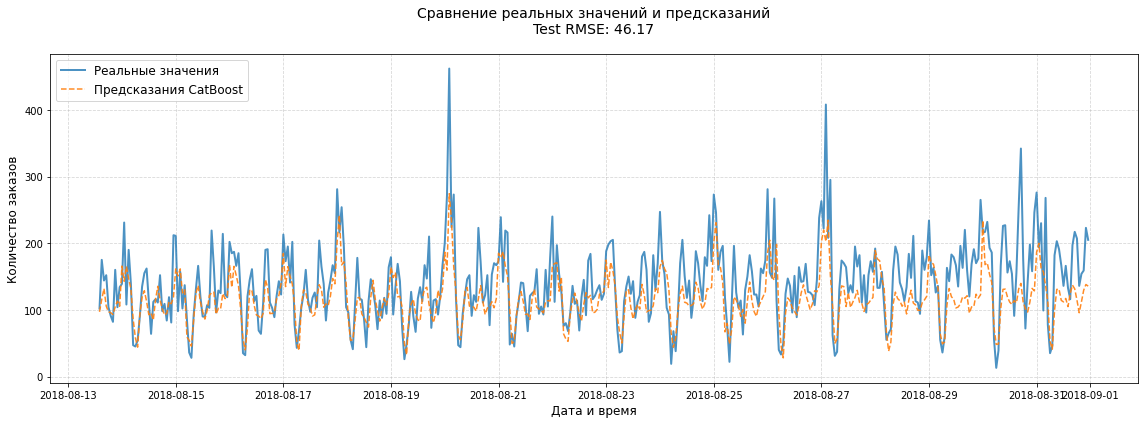

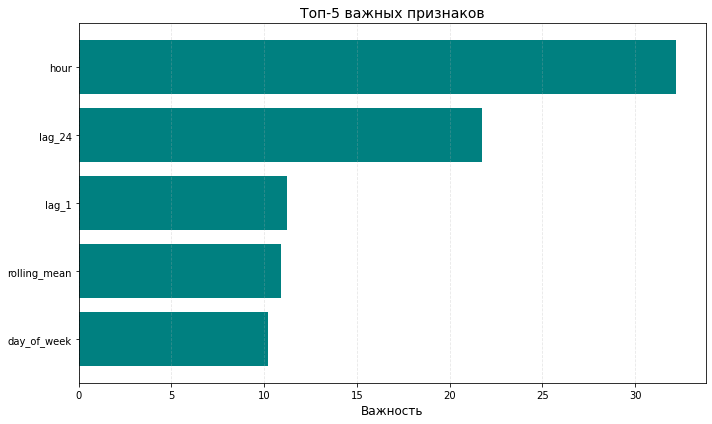

In [ ]:
# Проверка прогноза на тестовых данных
y_test_pred = best_cb.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Создание графика сравнения
plt.figure(figsize=(16, 6))

# Визуализация реальных значений и предсказаний
plt.plot(y_test.index, y_test, label='Реальные значения', color='#1f77b4', linewidth=2, alpha=0.8)
plt.plot(y_test.index, y_test_pred, label='Предсказания CatBoost', color='#ff7f0e',
         linestyle='--', linewidth=1.5, alpha=0.9)

# Настройки графика
plt.title(f'Сравнение реальных значений и предсказаний\nTest RMSE: {test_rmse:.2f}',
          fontsize=14, pad=20)
plt.xlabel('Дата и время', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Вывод важности признаков
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_cb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:5],
         feature_importance['importance'][:5],
         color='teal')
plt.title('Топ-5 важных признаков', fontsize=14)
plt.xlabel('Важность', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Значение модели CatBoost на тестовых данных не больше 48.  Результат удовлетворяет поставленной цели. Более низкий показатель на тесте может быть связан с большим количеством шума в этих данных (видели по анализу остатков).

После проведения исследования и обучения моделей была выбрана лучшая CatBoost. И использована в качестве основной для прогноза.  Модель на тестовой выборке показала хорошее значение RMSE - меньше 48.

## Ключевые выводы проекта "Прогнозирование заказов такси"

###  Результаты прогнозного моделирования

### CatBoost - **РЕКОМЕНДУЕМАЯ МОДЕЛЬ**:
- **Качество прогноза**: RMSE < 48 на тестовой выборке
- **Требования заказчика**: Полное соответствие (RMSE ≤ 48)
- **Надёжность**: Стабильные результаты прогнозирования

### Достигнутые цели проекта

### Основной критерий выполнены
- **RMSE на тесте**: Показатель ниже требуемых 48 единиц
- **Качество прогноза**: Модель точно предсказывает количество заказов на следующий час
- **Готовность к внедрению**: Модель соответствует производственным требованиям